In [14]:
from pandas import read_excel
from pandas import DataFrame
from pandas import merge
from statsmodels.formula.api import logit
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = read_excel('http://itpaper.co.kr/data/gradeuate.xlsx', engine='openpyxl')
df

,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
...,...,...,...,...
395,0,620,4.00,2
396,0,560,3.04,3
397,0,460,2.63,2
398,0,700,3.65,2


In [3]:
model = logit('합격여부 ~ 필기점수+학부성적+병원경력', data=df)
fit = model.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.574302
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   합격여부   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Mon, 21 Jun 2021   Pseudo R-squ.:                 0.08107
Time:                        14:41:22   Log-Likelihood:                -229.72
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 8.207e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4495      1.133     -3.045      0.002      -5.670      -1.229
필기점수           0.0023      0.

## 3) 결과해석

---

### 각 회귀계수가 합격여부에 미치는 영향

- 유의확률을 봤을 때 모든 계수의 pvalue가 0.05보다 작으므로 종속변수에 영향을 주는 유의한 변수임을 알 수 있다.
- 만약 0.05보다 큰 항목이 있다면 해당 변수를 제외하고 다시 분석을 수행해야 한다.
- 필기점수와 학부성적은 회귀계수가 양수이므로 각각 점수가 높을 수록 합격 확률이 높아진다.
- 병원경력은 음수이므로 경력이 많을 수록 합격 확률이 낮아진다.

In [4]:
# 오즈비
np.exp(fit.params)

Intercept    0.031760
필기점수         1.002297
학부성적         2.174967
병원경력         0.571191
dtype: float64

In [5]:
conf_tab = fit.pred_table()
conf_tab

array([[253.,  20.],
       [ 98.,  29.]])

In [6]:
conf_df = DataFrame(conf_tab, 
                    index=['True','False'], 
                    columns=['Positive', 'Negative'])
conf_df

,Positive,Negative
True,253.0,20.0
False,98.0,29.0


In [7]:
k = (conf_df['Positive']['True']+conf_df['Negative']['False']) / len(df)
print('분류 정확도 :', k)

분류 정확도 : 0.705


In [8]:
pred2 = fit.predict(df)
pred2

0      0.189553
1      0.317781
2      0.717814
3      0.148949
4      0.097954
         ...   
395    0.490176
396    0.184989
397    0.186814
398    0.468108
399    0.325045
Length: 400, dtype: float64

In [9]:
pdf = DataFrame(pred2, columns=['추정치'])
pdf['합격확률(%)'] = round(pdf['추정치']*100, 1)
pdf['예상결과'] = np.where(pdf['추정치'] > 0.5, "합격", "불합격")

result_df = merge(df, pdf, left_index=True, right_index=True)
result_df

,합격여부,필기점수,학부성적,병원경력,추정치,합격확률(%),예상결과
0,0,380,3.61,3,0.189553,19.0,불합격
1,1,660,3.67,3,0.317781,31.8,불합격
2,1,800,4.00,1,0.717814,71.8,합격
3,1,640,3.19,4,0.148949,14.9,불합격
4,0,520,2.93,4,0.097954,9.8,불합격
...,...,...,...,...,...,...,...
395,0,620,4.00,2,0.490176,49.0,불합격
396,0,560,3.04,3,0.184989,18.5,불합격
397,0,460,2.63,2,0.186814,18.7,불합격
398,0,700,3.65,2,0.468108,46.8,불합격


In [10]:
k = result_df['예상결과'].value_counts()
k

불합격    351
합격      49
Name: 예상결과, dtype: int64

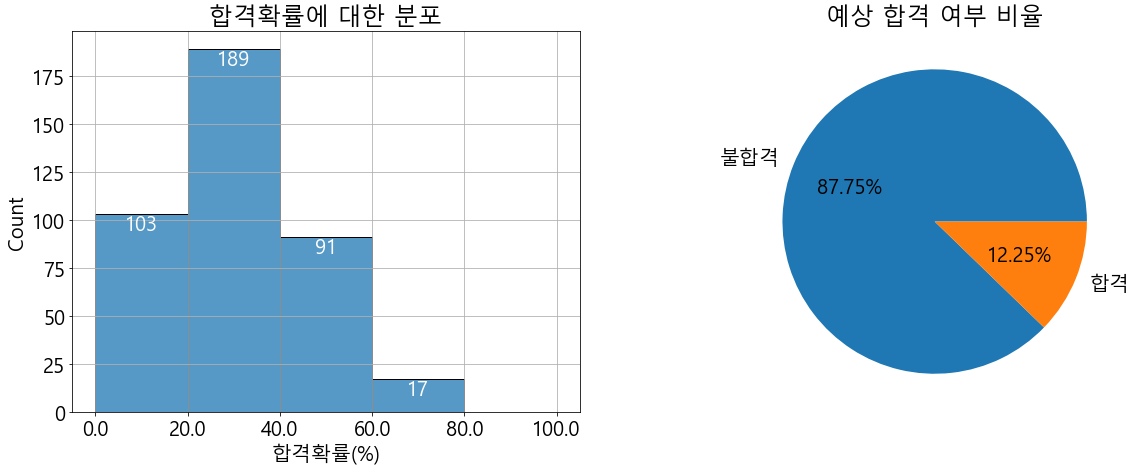

In [15]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 20

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

n, bins = np.histogram(result_df['합격확률(%)'], bins=5, range=(0, 100))
sns.histplot(x='합격확률(%)', data=result_df, bins=5, binrange=(0, 100), ax=ax[0])
ax[0].set_xticks(bins)
ax[0].set_xticklabels(bins)
ax[0].grid()
ax[0].set_title('합격확률에 대한 분포')

# 출력할 데이터 수 만큼 반복
for j, w in enumerate(n):    
    x = bins[j] + ((bins[j+1]-bins[j]) / 2)
    ax[0].text(x, w, str(int(w)), fontsize=20, color='#ffffff', horizontalalignment='center', verticalalignment='top')

ax[1].pie(k, labels=k.index, autopct='%.2f%%')
ax[1].set_title('예상 합격 여부 비율')

plt.show()